# Extracting a median centreline from an oriented 3d point cloud

This notebook follows the step by step extraction of a centreline from a point pcCave. The following limitation currently applies: the cave passage topology must fit in a planar graph, so overlapping passages are not supported.

The following calculations are performed: 
1. The cave point cloud (``pcCave``) is projected onto a plane by setting the Z coordinate to 0. A scalar field named ``isCave`` is added to the dataset.
2. A rectangular plane (``msPlane``) is sown with randomly distributed points (``pcPlane``), who are then given the value of scalar field ``isCave`` by interpolating this value from the projected cave point cloud scalar field. Points within the projected cave outline are thus given the value **1** while those outside are given **nan**.
3. The planar point cloud is split between the values inside (``isCave``) and outside (``notIsCave``).
4. A cloud to cloud distance is computed between ``isCave`` and ``notIsCave``, using the outside as reference. The distance computed is 0 at the boundary and increases towards the centerline, with a maximum distance to the point pcCave. 
5. Setting this distance as a Z coordinate, the roughness is calculated. Within a chosen radius, a plane is fitted to each point neighbourhood and the distance from the point of interest to this plane is the value of roughness returned. In a sense, this can be thought of as the curvature of the scalar field.
6. This new scalar field is then thresholded, with high positive values describing the centre crest of the 2d plot of X, Y, and maxdistance, kept as a ``centreline`` point pcCave. Because of its high linearity, this point cloud can be spatially subsampled aggressively, yielding a few hundred points remaining to describe the nodes of the extracted centreline.
7. A new scalar field is added to the thresholded and subsampled point set, namely, the interpolated Z coordinate of the projected cave point pcCave. The median Z value within a given sphere radius is attributed to each point of this centreline point pcCave.
8. The final step is to turn the point cloud into an oriented graph.

In [31]:
# start with the imports
import cloudComPy as cc
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from yaml import load
from yaml.loader import Loader

from helpers import catmullrom3d

In [32]:
font = {'family' : 'DejaVu Sans',
        'sans-serif': "Arial",
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10

## 1. Read the point cloud dataset and project it onto a horizontal plane with zero altitude

In [33]:
BASENAME = "11_Prerouge"
PASSAGE = "Chapelle"
fp = f"../../real_data/{BASENAME}/params.yaml"

params = load(open(fp), Loader)

In [34]:
fp_centrelines2D = os.path.join(params["paths"]["root"], params["paths"]["centrelines"], "2d")

In [35]:
fp_centrelines2D

'F:/ScanLeica/from_pointcloud_to_mesh/real_data/11_Prerouge\\process/centrelines\\2d'

In [36]:
centrelines2D = os.listdir(fp_centrelines2D)


In [37]:
centrelines2D

['Chapelle_1.poly']

In [38]:
RAW_CLOUD_FILEPATH = os.path.normpath(os.path.join(params["paths"]["root"], params["paths"]["subsampledGeorefOutCloudName"]))
GLOBAL_SHIFT = params["alignment"]["globalShift"]

if params["alignment"]["crs"] != "None":
    crs_str = params["alignment"]["crs"]
    CRS = f"({crs_str})"
else:
    CRS = ""

if params["alignment"]["elevation"] != "None":
    ELEVATION = params["alignment"]["elevation"]
else:
    ELEVATION = ""

# load the point cloud to memory but because it is georeferenced the x and y coordinates are very large.
# so we subtract the global shift determined in the processing parameters.
print(RAW_CLOUD_FILEPATH)
pcCave = cc.loadPointCloud(RAW_CLOUD_FILEPATH, cc.CC_SHIFT_MODE.XYZ, 0, *GLOBAL_SHIFT)
#pcCave = cc.loadPointCloud(f"../../real_data/{BASENAME}/output/{PASSAGE}_clean.ply", cc.CC_SHIFT_MODE.XYZ, 0, *GLOBAL_SHIFT)

F:\ScanLeica\from_pointcloud_to_mesh\real_data\11_Prerouge\output\Prerouge-Chapelle-Edytem-2016_subsampled.las


In [39]:
pcCavesubsampled = cc.loadPointCloud(RAW_CLOUD_FILEPATH, cc.CC_SHIFT_MODE.XYZ, 0, *GLOBAL_SHIFT)


In [40]:
GLOBAL_SHIFT

[0, 0, 0]

In [41]:
# add new scalar fields, these are initialised with a value of 0. So we fill the isCave field with 1s.
pcCave.addScalarField("Z0")

3

In [42]:
# because we are going to project the cloud onto a plane, we save the original Z coordinate 
# as a scalar which we are going to retrieve later on.
isXexported=False
isYexported=False
isZexported=True

pcCave.exportCoordToSF(isXexported, isYexported, isZexported)
pcCavesubsampled.exportCoordToSF(isXexported, isYexported, isZexported)

True

In [43]:
d = pcCave.getScalarFieldDic()
print(d)

{'Coord. Z': 4, 'Intensity': 0, 'Number Of Returns': 2, 'Return Number': 1, 'Z0': 3}


In [44]:
# extracting the coordinates as an np.array
coords = pcCave.toNpArrayCopy()
# setting Z0 as the coordinate z to project the original point cloud onto a plane at altitude 0.
coords[:,2] = pcCave.getScalarField("Z0").toNpArrayCopy()
# setting the cloud coordinates from the updated np.array
pcCave.coordsFromNPArray_copy(coords)

In [45]:
# Coord Z is the scalar field to be displayed
pcCave.setCurrentDisplayedScalarField(d["Coord. Z"])
pcCave.setCurrentScalarField(d["Coord. Z"])

## Reading the centreline file to a cloud on which to interpolate Coord Z. 

In [46]:
os.path.join(fp_centrelines2D, centrelines2D[0])

'F:/ScanLeica/from_pointcloud_to_mesh/real_data/11_Prerouge\\process/centrelines\\2d\\Chapelle_1.poly'

In [47]:
def arrayToCCPolyline2D(polyline):
    polyCloud = cc.ccPointCloud("polyline")
    polyline_shifted = polyline + np.array(GLOBAL_SHIFT)
    polyline_shifted[:,2] = np.zeros(len(polyline))
    polyCloud.coordsFromNPArray_copy(polyline_shifted)

    boxLine = cc.ccPolyline(polyCloud)
    boxLine.addChild(polyCloud)
    boxLine.addPointIndex(0, polyCloud.size())
    print(f"Centreline bounding box: {boxLine.getBoundingBox()}")
    return boxLine

In [48]:
def interpolate3DCentreline(fp, pcCave):
    # load the polyline and create a 2d cc polyline.
    print(f"filepath: {fp}")
    polyline2d = np.loadtxt(fp)
    CCcentreline2d = arrayToCCPolyline2D(polyline2d)
    
    pc_CCcentreline2d = CCcentreline2d.getAssociatedCloud()
    d = pcCave.getScalarFieldDic()
    print(d)
    print(f"Centreline bounds: {pc_CCcentreline2d.getOwnBB().minCorner()} {pc_CCcentreline2d.getOwnBB().maxCorner()}")
    print(f"Point cloud bounds:{pcCave.getOwnBB().minCorner()} {pcCave.getOwnBB().maxCorner()}")

    params = cc.interpolatorParameters()
    params.method = cc.INTERPOL_METHOD.RADIUS
    params.algos = cc.INTERPOL_ALGO.NORMAL_DIST
    params.radius = 5
    params.sigma = 5
    print(d["Coord. Z"])
    sfIndexes = [d["Coord. Z"]]

    ret = cc.interpolateScalarFieldsFrom(pc_CCcentreline2d, pcCave, sfIndexes, params, octreeLevel=11)
    print(pc_CCcentreline2d.getScalarFieldDic())
    interpolated_Z = pc_CCcentreline2d.getScalarField("Coord. Z").toNpArray()

    print(interpolated_Z)
    # in order to split this planar point cloud between pcIsCave and pcNotIsCave clouds, we need to 
    polyline3d = pc_CCcentreline2d.toNpArrayCopy()
    polyline3d[:, 2] = interpolated_Z
    polyline3d = polyline3d - np.array(GLOBAL_SHIFT)
    # save to poly.
    np.savetxt("3d".join((fp_polyline.strip(".poly")+"_z_interp_3d.poly").split("2d")), polyline3d)

    return polyline3d

In [49]:
fp_polyline = os.path.normpath(os.path.join(fp_centrelines2D, centrelines2D[0]))


centrelines3d = []
centreline3d = interpolate3DCentreline(fp_polyline, pcCave)
centrelines3d.append(centreline3d)
    

filepath: F:\ScanLeica\from_pointcloud_to_mesh\real_data\11_Prerouge\process\centrelines\2d\Chapelle_1.poly
Centreline bounding box: [(89.96096801757812, 100.95306396484375, 0.0), (120.5398941040039, 169.9116668701172, 0.0)]
{'Coord. Z': 4, 'Intensity': 0, 'Number Of Returns': 2, 'Return Number': 1, 'Z0': 3}
Centreline bounds: (89.96096801757812, 100.95306396484375, 0.0) (120.5398941040039, 169.9116668701172, 0.0)
Point cloud bounds:(-24.76259994506836, 43.64830017089844, 0.0) (158.4010009765625, 202.3513946533203, 0.0)
4
{'Coord. Z': 0}
[14.799452  14.660149  14.4646015 14.162147  13.749237  13.164221
 12.324078  11.499582  10.488662   9.383042   8.407273   7.1678348
  6.319575 ]


In [50]:
# import the z coordinate again.
cave_Z = pcCave.getScalarField("Coord. Z").toNpArrayCopy()

caveCoords = pcCave.toNpArrayCopy()
caveCoords[:, 2] = cave_Z

pcCave.coordsFromNPArray_copy(caveCoords)

In [51]:
dropna = centrelines3d[0][:, 2] >= 0

In [52]:
centrelines3d[0][dropna]

array([[120.5398941 , 169.91166687,  14.79945183],
       [118.56370544, 165.4392395 ,  14.66014862],
       [116.48350525, 160.86279297,  14.46460152],
       [114.50731659, 154.72621155,  14.16214657],
       [113.25919342, 150.46180725,  13.74923706],
       [110.76295471, 145.67733765,  13.16422081],
       [108.68276215, 139.95680237,  12.32407761],
       [106.60256195, 134.86030579,  11.49958229],
       [105.0424118 , 129.55580139,  10.48866177],
       [100.88201141, 123.31520844,   9.38304234],
       [ 97.03364563, 116.03450775,   8.40727329],
       [ 93.28928375, 106.6736145 ,   7.16783476],
       [ 89.96096802, 100.95306396,   6.31957483]])

In [53]:
NUM_POINTS = 10
split_chain_points: list = catmullrom3d.catmull_rom_chain(centrelines3d[0][dropna], NUM_POINTS, is3d=True)
assert len(split_chain_points) == catmullrom3d.num_segments(centrelines3d[0][dropna]) * NUM_POINTS  # 400 blue points for this example

spline_centreline = np.vstack(split_chain_points)
np.savetxt("3d".join((fp_polyline.strip(".poly")+"_z_interp_3d_spline.poly").split("2d")), spline_centreline)


In [54]:
from scipy.interpolate import interp1d

In [55]:
# curvilinear coordinate. 

curvilinear = np.cumsum(np.linalg.norm(np.diff(spline_centreline, axis = 0), axis = 1))
curvilinear = np.pad(curvilinear, (1, 0), "constant", constant_values = (0, 0))

In [56]:
def parametrise_centreline(t, centreline):
    
    curvilinear = np.cumsum(np.linalg.norm(np.diff(centreline, axis = 0), axis = 1))
    curvilinear = np.pad(curvilinear, (1, 0), "constant", constant_values = (0, 0))

    # interpolate linearly
    fx = interp1d(curvilinear, centreline[:, 0])
    fy = interp1d(curvilinear, centreline[:, 1])
    fz = interp1d(curvilinear, centreline[:, 2])

    return np.vstack([fx(t), fy(t), fz(t)]).T


In [62]:
spline_parametrised = parametrise_centreline(np.arange(0, 65, 0.5), spline_centreline)

np.savetxt("3d".join((fp_polyline.strip(".poly")+"_z_interp_3d_spline.poly").split("2d")), spline_parametrised)


In [63]:
norm = mpl.colors.Normalize(vmin=min(cave_Z)-GLOBAL_SHIFT[2], vmax=max(cave_Z)-GLOBAL_SHIFT[2])
cmap = mpl.cm.viridis

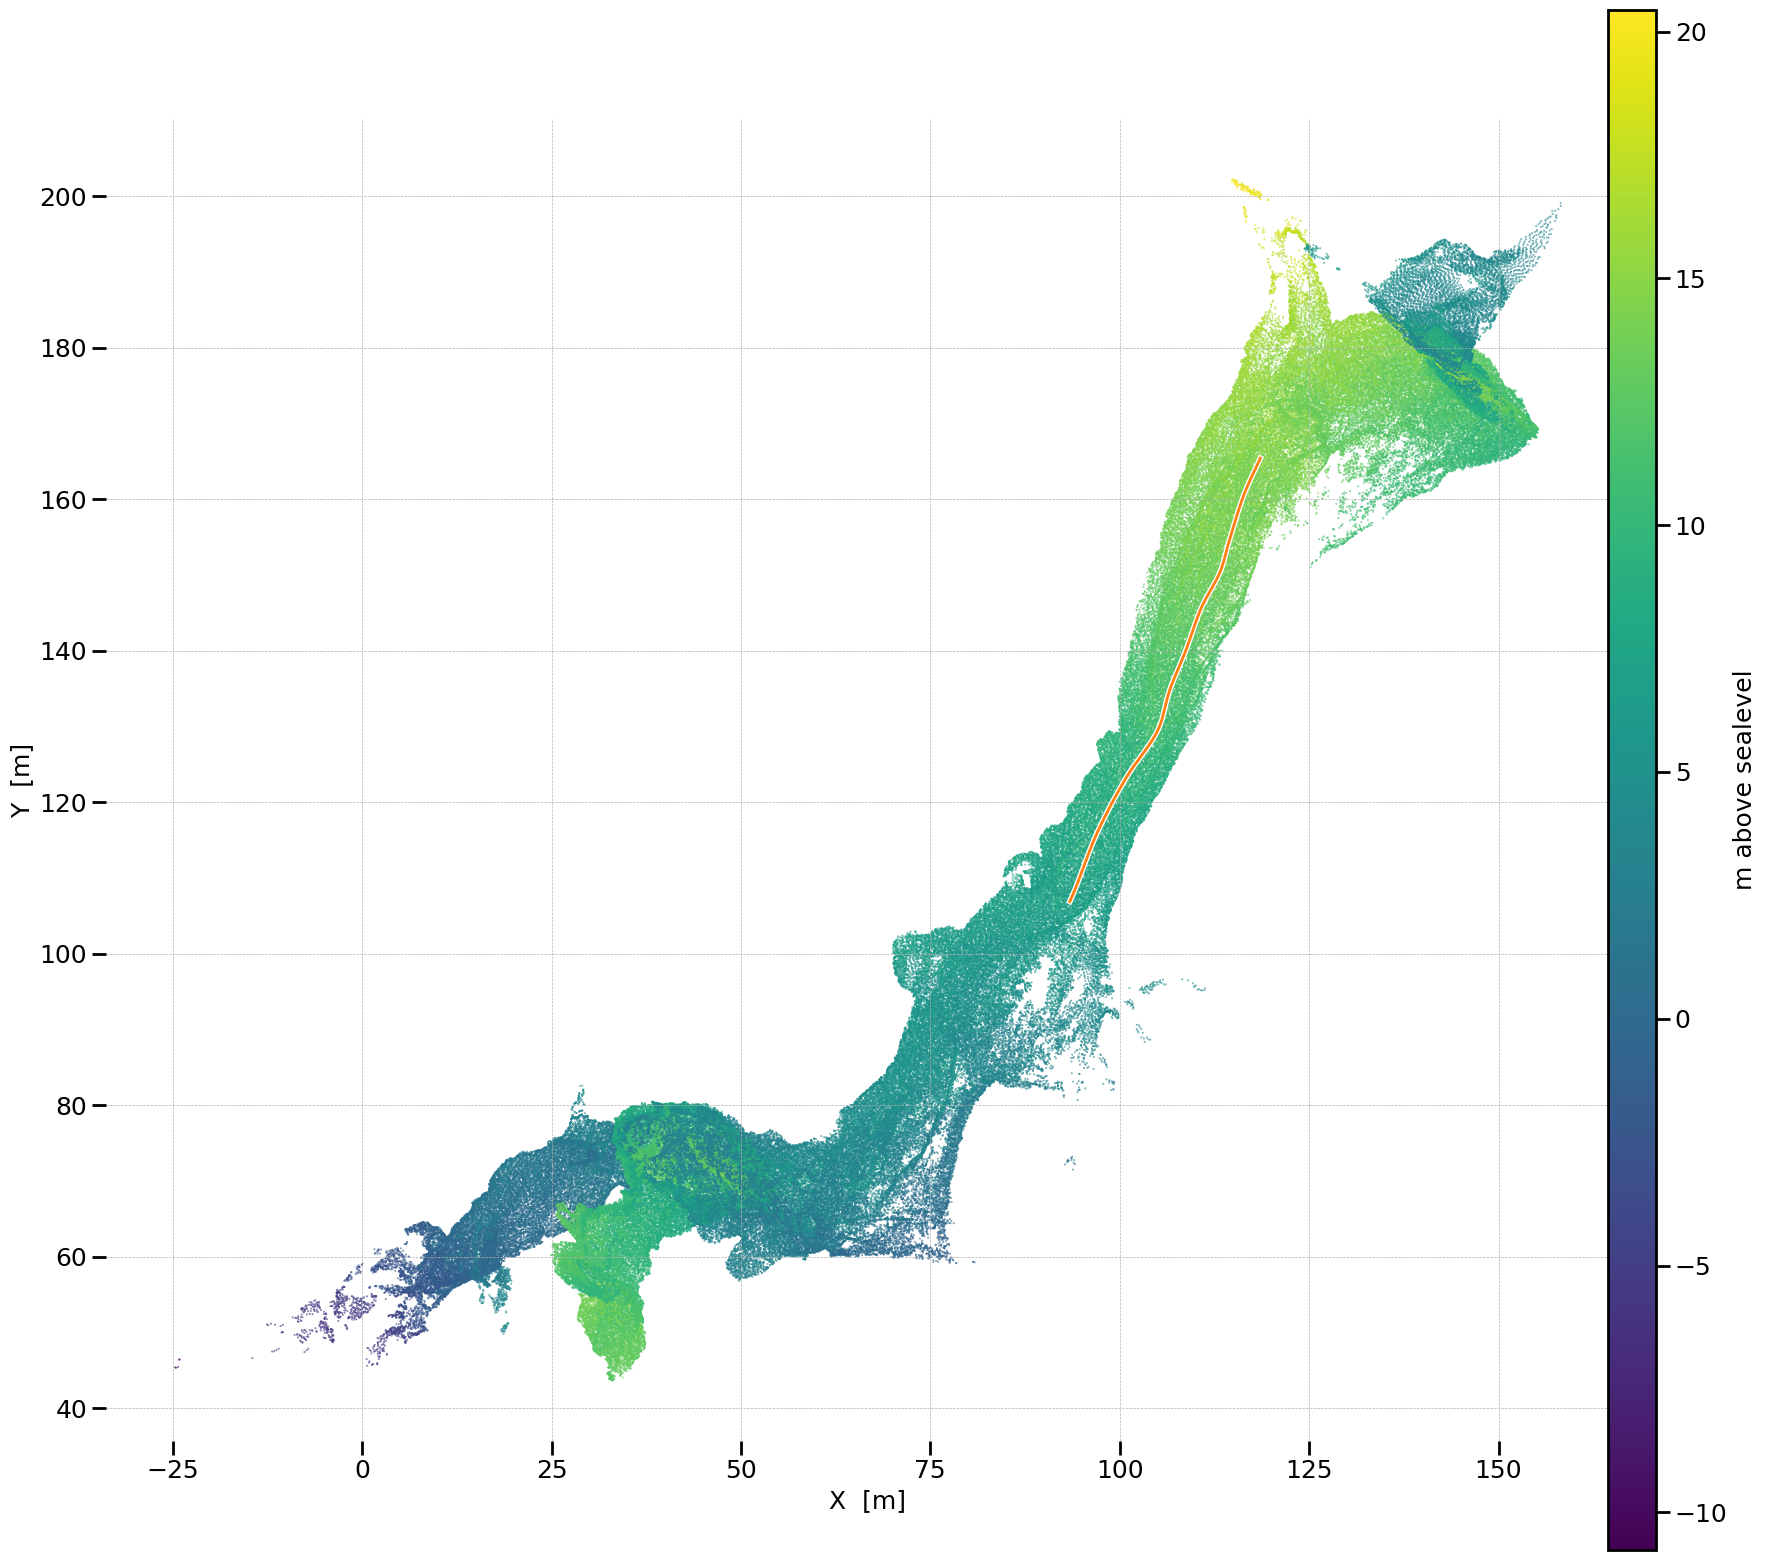

In [64]:
fig = plt.figure(figsize = (20, 20))
gs = GridSpec(1, 60)

ax = fig.add_subplot(gs[:59])
cax = fig.add_subplot(gs[58:])
dense_cave = pcCave.toNpArrayCopy() - GLOBAL_SHIFT
sparse_cave = pcCavesubsampled.toNpArrayCopy() - GLOBAL_SHIFT

cave_Z = pcCavesubsampled.getScalarField("Coord. Z").toNpArrayCopy()
#ax.plot(centrelines3d[0][:,0], centrelines3d[0][:,1], color = "C1", lw = 2)
#ax.plot(spline_centreline[:,0], spline_centreline[:,1], color = "w", lw = 4)
#ax.plot(spline_centreline[:,0], spline_centreline[:,1], color = "C1", lw = 2)

ax.plot(spline_parametrised[:,0], spline_parametrised[:,1], color = "w", lw = 4)
ax.plot(spline_parametrised[:,0], spline_parametrised[:,1], color = "C1", lw = 2)
ax.scatter(sparse_cave[::10,0], sparse_cave[::10,1], s = 0.1, zorder = -100,c=cave_Z[::10], cmap = "viridis")

ax.set_aspect("equal")

ax.set_xlabel(f"X {CRS} [m]")
ax.set_ylabel(f"Y {CRS} [m]")

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical', label='m above sealevel', fraction=0.01)

#ax.text(516252, 172082, "PLAN", fontsize=21)
#ax.text(537795, 195168, "Couloir du Bourbier", fontsize=21, color = "C1")
#ax.text(537630, 195222, "La Cave", fontsize = 21, color = "C1")

ax.grid(lw = 0.5, ls="--")

for side in ("top", "left", "right", "bottom"):
    ax.spines[side].set_visible(False)

plt.savefig(f"../../real_data/{BASENAME}/output/{PASSAGE}_VueEnPlan.png", dpi = 300)

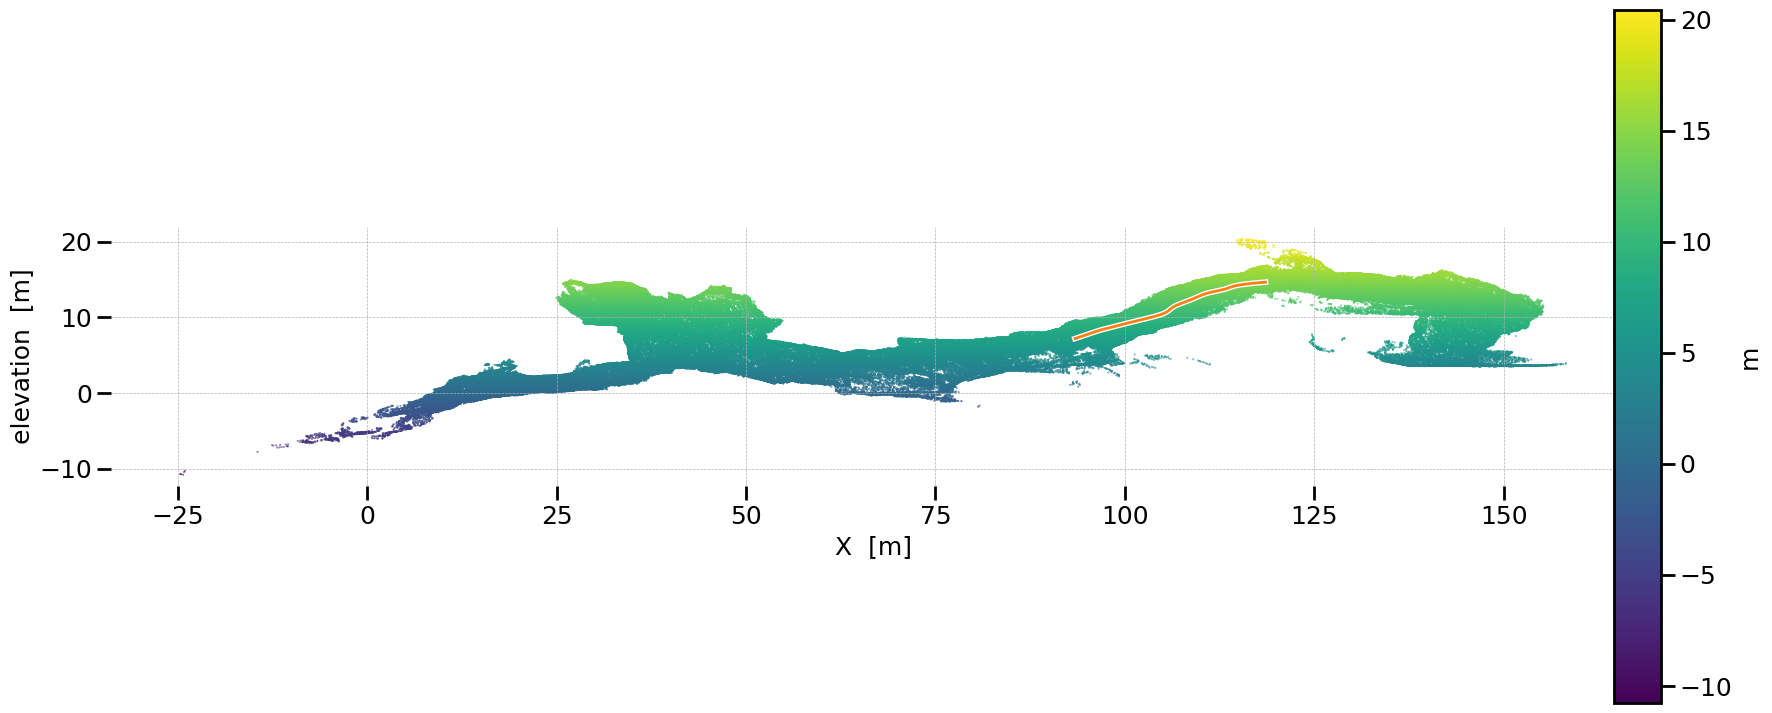

In [65]:
fig = plt.figure(figsize = (20, 9))
gs = GridSpec(1, 60)

ax = fig.add_subplot(gs[:59])
cax = fig.add_subplot(gs[58:])


#ax.set_ylim(741, 810)

ax.scatter(sparse_cave[::10,0], sparse_cave[::10,2], s = 0.1, zorder = -100,c=cave_Z[::10], cmap = "viridis")
#for centreline in centrelines3d:
    #ax.plot(centreline[:,0], centreline[:,2], color = "C1", lw = 2)

ax.plot(spline_parametrised[:,0], spline_parametrised[:,2], color = "w", lw = 4)
ax.plot(spline_parametrised[:,0], spline_parametrised[:,2], color = "C1", lw = 2)

ax.set_aspect("equal")

ax.set_xlabel(f"X {CRS} [m]")
ax.set_ylabel(f"elevation {ELEVATION} [m]")
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical', label='m', fraction=0.01)

#ax.text(516255, 842, "PROJECTED PROFILE (000)", fontsize=21)
#ax.text(537785, 752, "Couloir du Bourbier", fontsize=21, color = "C1")
#ax.text(537630, 752, "La Cave", fontsize = 21, color = "C1")

ax.grid(lw = 0.5, ls="--")

for side in ("top", "left", "right", "bottom"):
    ax.spines[side].set_visible(False)

plt.savefig(f"../../real_data/{BASENAME}/output/{PASSAGE}_VueEnProfil.png", dpi = 300)